In [1]:
import math

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import seaborn as sns
import torch

sns.set_theme()

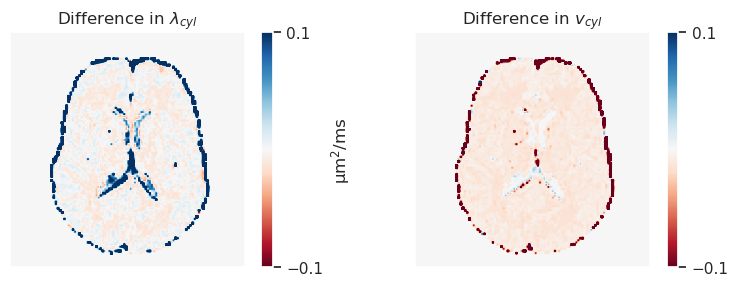

In [2]:
# Show difference in maps

params_uniform = nib.load("params_uniform.nii.gz").get_fdata()
params_healthy_brain = nib.load("params_healthy_brain.nii.gz").get_fdata()

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
im = ax[0].imshow(
    np.rot90((params_uniform - params_healthy_brain)[..., 30, 0]),
    vmin=-0.1,
    vmax=0.1,
    cmap="RdBu",
)
cbar = plt.colorbar(im)
cbar.set_ticks([-0.1, 0.1])
cbar.set_label(r"μm$^2$/ms")
im = ax[1].imshow(
    np.rot90((params_uniform - params_healthy_brain)[..., 30, 1]),
    vmin=-0.1,
    vmax=0.1,
    cmap="RdBu",
)
cbar = plt.colorbar(im)
cbar.set_ticks([-0.1, 0.1])
ax[0].set_title(r"Difference in $\lambda_{cyl}$")
ax[1].set_title(r"Difference in $v_{cyl}$")
for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].grid(False)
fig.tight_layout()
plt.show()

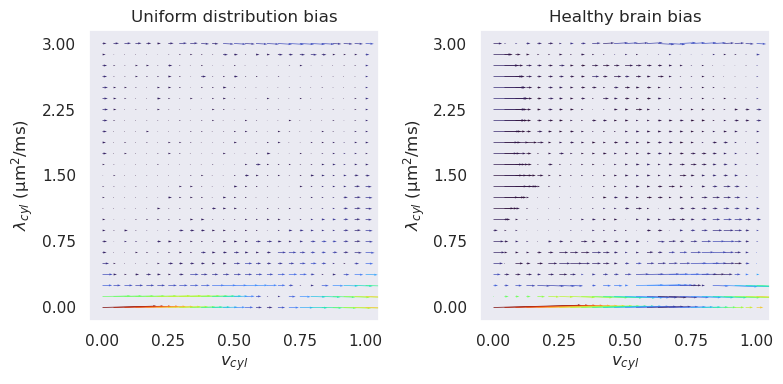

In [12]:
# Show the bias for different parameter values

bvals = torch.tensor([1, 2.2])


def E(bvals, lambda_cyls, v_cyls):
    return v_cyls.unsqueeze(1) * (
        math.sqrt(math.pi)
        * torch.erf(torch.sqrt(bvals.unsqueeze(0) * lambda_cyls.unsqueeze(1)))
        / (2 * torch.sqrt(bvals.unsqueeze(0) * lambda_cyls.unsqueeze(1)))
    ) + (1 - v_cyls).unsqueeze(1) * (
        math.sqrt(math.pi)
        * torch.erf(
            torch.sqrt(
                bvals.unsqueeze(0)
                * (
                    lambda_cyls.unsqueeze(1)
                    - ((1 - v_cyls).unsqueeze(1) * lambda_cyls.unsqueeze(1))
                )
            )
        )
        / (
            2
            * torch.sqrt(
                bvals.unsqueeze(0)
                * (
                    lambda_cyls.unsqueeze(1)
                    - ((1 - v_cyls).unsqueeze(1) * lambda_cyls.unsqueeze(1))
                )
            )
        )
    ) * torch.exp(
        -bvals.unsqueeze(0) * ((1 - v_cyls).unsqueeze(1) * lambda_cyls.unsqueeze(1))
    )


model_uniform = torch.nn.Sequential(
    torch.nn.Linear(2, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 2),
)
model_uniform.load_state_dict(torch.load("weights_uniform.pt"))
model_uniform.eval()

model_healthy_brain = torch.nn.Sequential(
    torch.nn.Linear(2, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 2),
)
model_healthy_brain.load_state_dict(torch.load("weights_healthy_brain.pt"))
model_healthy_brain.eval()

lambda_cyls, v_cyls = torch.meshgrid(
    torch.linspace(1e-6, 3, 25), torch.linspace(1e-6, 1, 25)
)
lambda_cyls = lambda_cyls.ravel()
v_cyls = v_cyls.ravel()
targets = torch.vstack((lambda_cyls, v_cyls)).T
signals = E(bvals, lambda_cyls, v_cyls)
with torch.no_grad():
    preds_uniform = model_uniform(signals)
    preds_healthy_brain = model_healthy_brain(signals)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
im = ax[0].quiver(
    v_cyls,
    lambda_cyls,
    (preds_uniform - targets)[:, 0],
    (preds_uniform - targets)[:, 1],
    torch.linalg.norm((preds_uniform - targets), dim=1),
    cmap="turbo",
    scale=1,
    scale_units="xy",
    angles="yx",
    pivot="tail",
)
ax[1].quiver(
    v_cyls,
    lambda_cyls,
    (preds_healthy_brain - targets)[:, 0],
    (preds_healthy_brain - targets)[:, 1],
    torch.linalg.norm((preds_uniform - targets), dim=1),
    cmap="turbo",
    scale_units="xy",
    angles="yx",
    scale=1,
    pivot="tail",
)
ax[0].set_title(r"Uniform distribution bias")
ax[1].set_title(r"Healthy brain bias")
for i in range(2):
    ax[i].grid(False)
    ax[i].set_xticks(np.linspace(0, 1, 5))
    ax[i].set_yticks(np.linspace(0, 3, 5))
    ax[i].set_xlabel(r"$v_{cyl}$")
    ax[i].set_ylabel(r"$\lambda_{cyl}$ (μm$^2$/ms)")
fig.tight_layout()
plt.show()